# Sample Notebook
This is a slight retooling of Vaclav Petras' [_Try Grass in Jupyter_ notebook](https://github.com/wenzeslaus/try-grass-in-jupyter/blob/master/notebook.ipynb). 

## Download sample data

Download North Carolina data.  We have to change the owner to preent user (root in this case), as it appears there is an issue in GRASS that you must own the files.  

In [ ]:
%%bash
wget https://grass.osgeo.org/sampledata/north_carolina/nc_spm_08_grass7.tar.gz
mv nc_spm_08_grass7.tar.gz data/grassdata
cd data/grassdata
tar -xf nc_spm_08_grass7.tar.gz
# this next line is unfortunately needed we must own the file. (we are root in this container)
chown -R root nc_spm_08_grass7/
cd -

## Import stuff, open files
Here we import libraries and open the NC dataset.
Note that in this section we have to decode the bytes for gisbase.

In [26]:
# Import Python standard library and IPython packages we need.
import os
import sys
import subprocess
from IPython.display import Image

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(['grass', '--config', 'path']).strip().decode('utf-8')
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, 'etc', 'python'))

# path to sample data
grassdata = 'data/grassdata'

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.script.setup as gsetup

# Create a GRASS GIS session.
rcfile = gsetup.init(gisbase, dbase=grassdata, location='nc_spm_08_grass7')

# We want functions to raise exceptions and see standard output of the modules in the notebook.
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)
# Simply overwrite existing maps like we overwrite Python variable values.
os.environ['GRASS_OVERWRITE'] = '1'
# Enable map rendering in a notebook.
os.environ['GRASS_FONT'] = 'sans'
# Set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'


## Raster buffer

Set computational region and create multiple buffers in given distances around lakes represented as raster:


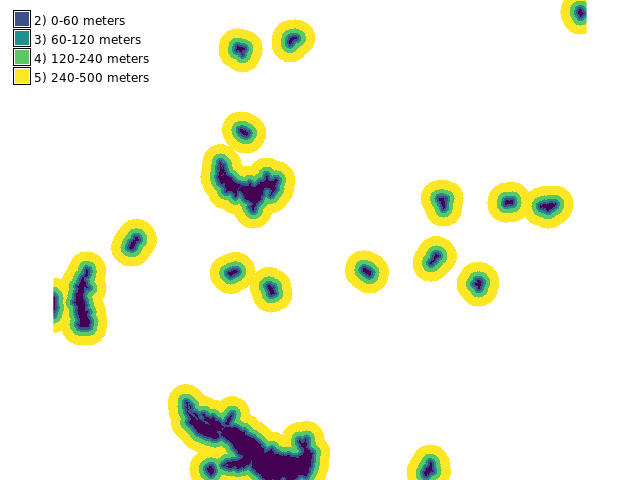

In [28]:
gs.parse_command('g.region', raster='lakes', flags='pg')
gs.run_command('r.buffer', input='lakes', output='lakes_buff', distances=[60, 120, 240, 500])
gs.run_command('d.erase')
gs.run_command('d.rast', map='lakes_buff')
gs.run_command('d.legend', raster='lakes_buff', range=(2, 5), at=(80, 100, 2, 10))
Image(filename='map.png')


## Vector buffer

Create a negative buffer around state boundary represented as a vector. Vector modules typically don't follow computational region, but we set it to inform display modules about our area of interest.


In [35]:
# see what vector data exists
gs.run_command('g.list', type='vector')

P079214
P079215
P079218
P079219
boundary_county
boundary_municp
bridges
buffer
busroute1
busroute11
busroute6
busroute_a
busroutesall
busstopsall
census_wake2000
censusblk_swwake
comm_colleges
elev_lid792_bepts
elev_lid792_cont1m
elev_lid792_randpts
elev_lidrural_mrpts
elev_lidrural_mrptsft
elev_ned10m_cont10m
firestations
geodetic_pts
geodetic_swwake_pts
geology
geonames_NC
geonames_wake
hospitals
lakes
nc_state
overpasses
poi_names_wake
precip_30ynormals
precip_30ynormals_3d
railroads
roadsmajor
schools_wake
soils_general
soils_wake
streams
streets_wake
swwake_10m
urbanarea
usgsgages
zipcodes_wake


0

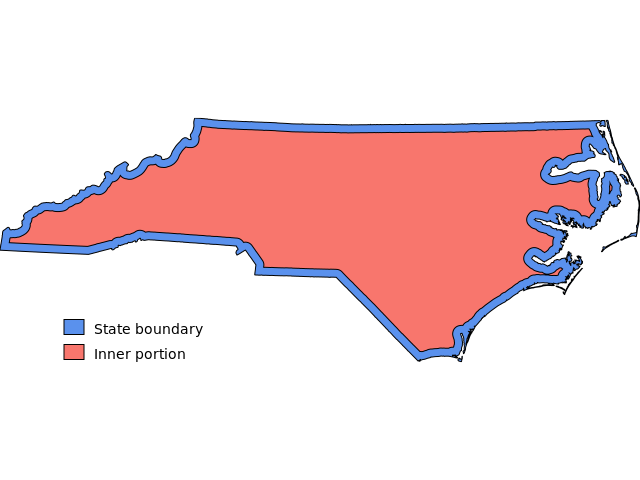

In [34]:
gs.run_command('v.buffer', input='nc_state', output='buffer', distance=-10000)
gs.parse_command('g.region', vector='nc_state', flags='pg')
gs.run_command('d.erase')  # erase the display before drawing again
!rm -f $GRASS_LEGEND_FILE  # and remove the legend file
gs.run_command('d.vect', map='nc_state', fill_color='#5A91ED', legend_label='State boundary')
gs.run_command('d.vect', map='buffer', fill_color='#F8766D', legend_label='Inner portion')
gs.run_command('d.legend.vect', at=(10, 35))
Image(filename='map.png')